# Potato Disease Classification

### Using CNN

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #rgb channels
EPOCHS = 40

Creating tensor dataset

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

    

2023-02-21 23:52:40.976420: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Function to split the dataset

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

54

In [10]:
len(val_ds)

6

In [11]:
len(test_ds)

8

Cache and prefetch for faster training

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resize and rescale

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### CNN Model with 6 convo and pooling layer

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
from tensorflow.keras.optimizers.legacy import Adam
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40
54/54 [==============================] - 34s 599ms/step - loss: 0.9132 - accuracy: 0.5156 - val_loss: 0.7997 - val_accuracy: 0.7135
Epoch 2/40
54/54 [==============================] - 31s 581ms/step - loss: 0.6984 - accuracy: 0.7083 - val_loss: 0.5622 - val_accuracy: 0.6979
Epoch 3/40
54/54 [==============================] - 32s 595ms/step - loss: 0.4760 - accuracy: 0.8009 - val_loss: 0.3556 - val_accuracy: 0.8594
Epoch 4/40
54/54 [==============================] - 31s 579ms/step - loss: 0.3497 - accuracy: 0.8582 - val_loss: 0.4766 - val_accuracy: 0.7708
Epoch 5/40
54/54 [==============================] - 31s 576ms/step - loss: 0.2942 - accuracy: 0.8854 - val_loss: 0.2762 - val_accuracy: 0.8906
Epoch 6/40
54/54 [==============================] - 31s 572ms/step - loss: 0.3153 - accuracy: 0.8785 - val_loss: 0.2175 - val_accuracy: 0.9167
Epoch 7/40
54/54 [==============================] - 32s 585ms/step - loss: 0.2233 - accuracy: 0.9126 - val_loss: 0.3333 - val_accuracy: 0.8594

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 157ms/step - loss: 0.0104 - accuracy: 0.9922


In [22]:
scores

[0.010351607576012611, 0.9921875]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])

list

In [27]:
len(history.history['loss'])

40

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9131817817687988,
 0.6984452605247498,
 0.47603240609169006,
 0.34974950551986694,
 0.2941674590110779]

Plot of Accuracy

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [30]:
range(EPOCHS)

range(0, 40)

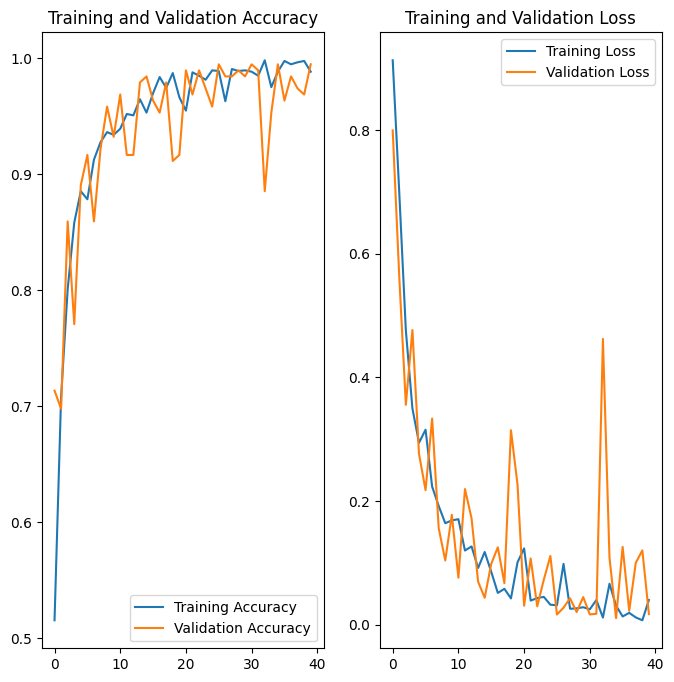

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 226ms/step
predicted label: Potato___Early_blight


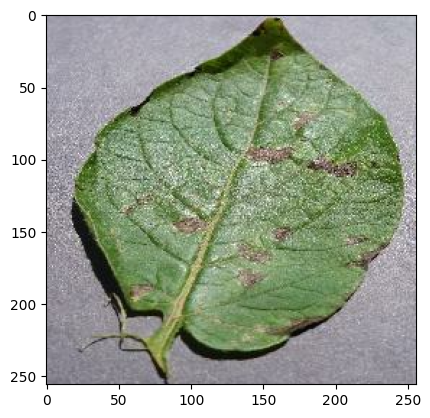

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


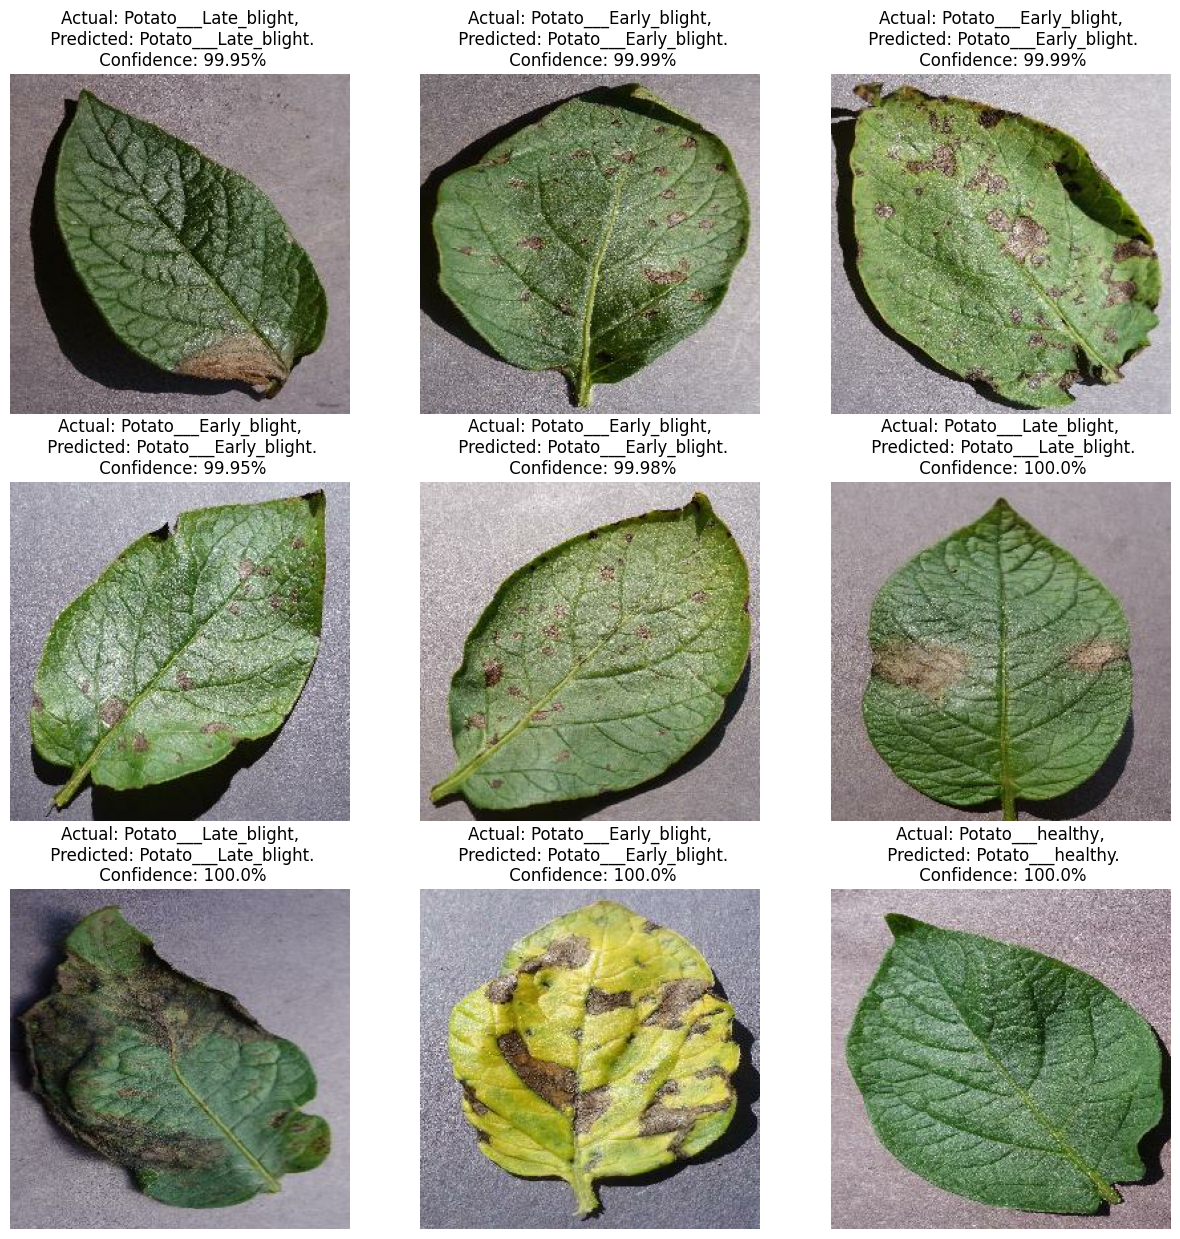

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the model

In [46]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [1]:
! pip install tensorflowjs

  Using cached tensorflowjs-4.2.0-py3-none-any.whl (84 kB)
  Using cached jax-0.4.4.tar.gz (1.2 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 835.3 kB/s eta 0:00:00
  Using cached tensorflowjs-4.1.0-py3-none-any.whl (84 kB)
  Using cached tensorflowjs-4.0.0-py3-none-any.whl (83 kB)
  Using cached tensorflowjs-3.21.0-py3-none-any.whl (81 kB)
  Using cached flax-0.6.6-py3-none-any.whl (210 kB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached tensorflowjs-3.20.0-py3-none-any.whl (81 kB)
  Using cached tensorflowjs-3.19.0-py3-none-any.whl (78 kB)
  Using cached tensorflowjs-3.18.0-py3-none-any.whl (77 kB)
  Using cached tensorflowjs-3.17.0-py3-none-any.whl (77 kB)
  Using cached tensorflowjs-3.15.0-py3-none-any.whl (77 kB)
  Using cached tensorflowjs-3.14.0-py3-none-any.whl (77 kB)
  Using cached tensorflowjs-3.13.0-py3-none-any.whl (77 kB)
  Using cached tensorflowjs-3.12.0-py3-none-any.whl (77 kB)
 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 2.2 MB/s eta 0:00:0000:0100:01m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 1.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
ERROR: Cannot install tensorflowjs==0.1.0, tensorflowjs==0.1.1, tensorflowjs==0.1.2, tensorflowjs==0.2.0, tensorflowjs==0.2.1, tensorflowjs==0.3.0, tensorflowjs==0.3.1, tensorflowjs==0.4.0, tensorflowjs==0.4.1, tensorflowjs==0.4.2, tensorflowjs==0.5.0, tensorflowjs==0.5.2, tensorflowjs==0.5.4, tensorflowjs==0.5.6, 